In [28]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
import dill
from tqdm.notebook import tqdm

import torch
import torch.distributions as dist

import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import VariationalStrategy, UnwhitenedVariationalStrategy
from gpytorch.likelihoods.likelihood import _OneDimensionalLikelihood

from pymc3.gp.util import plot_gp_dist

from data.data import get_data

In [29]:
%config InlineBackend.figure_format = "retina"
sns.set_context("paper")

In [30]:
def plot_gp(data, model, likelihood):
    
    # extract data
    train_x = torch.from_numpy(data.age.values).double()
    train_y = torch.from_numpy(data.height.values).double()
    
    # Get into evaluation (predictive posterior) mode
    model.eval()
    likelihood.eval()

    # Make predictions by feeding model through likelihood
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        test_x = torch.linspace(0, data.age.max(), 50).double()
        observed_pred = likelihood(model(test_x))

    with torch.no_grad():
        # Initialize plot
        f, ax = plt.subplots(figsize=(10, 7))

        # Get upper and lower confidence bounds
        lower, upper = observed_pred.confidence_region()
        # Plot training data as black stars
        ax.plot(train_x.numpy(), train_y.numpy(), 'x', alpha=0.3, color="black")
        # Plot predictive means as blue line
        ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'C0')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.3)

        ax.legend(['Observed Data', 'Mean', 'Confidence'])
    
    ax.set_xlabel("age")
    ax.set_ylabel("height")

In [31]:
data = get_data()

In [32]:
df_dm = pd.read_pickle("bkp/dm_growth.pkl")
df_dm.dm = df_dm.dm.apply(lambda x: dill.loads(x))
df_dm.index = df_dm.m
df_dm.drop("m", axis=1, inplace=True)
df_dm

,dm,theta,noise_init_value,epochs,learning_rate
m,,,,,
Linf,<discrepancy_modeling.discrepancy_modeling.Dis...,"[67.44565696442936, 6.476997071345798]",50,1000,0.1
Logf,<discrepancy_modeling.discrepancy_modeling.Dis...,"[1.3735350573348428, 5.217781791037082, -1.537...",50,1000,0.1
Jpps,<discrepancy_modeling.discrepancy_modeling.Dis...,"[180.96054145982922, -0.5599771932567534, 13.4...",50,1000,0.1
gp,<gp_regression.gp_regression.GPRegression obje...,None,50,5000,0.1


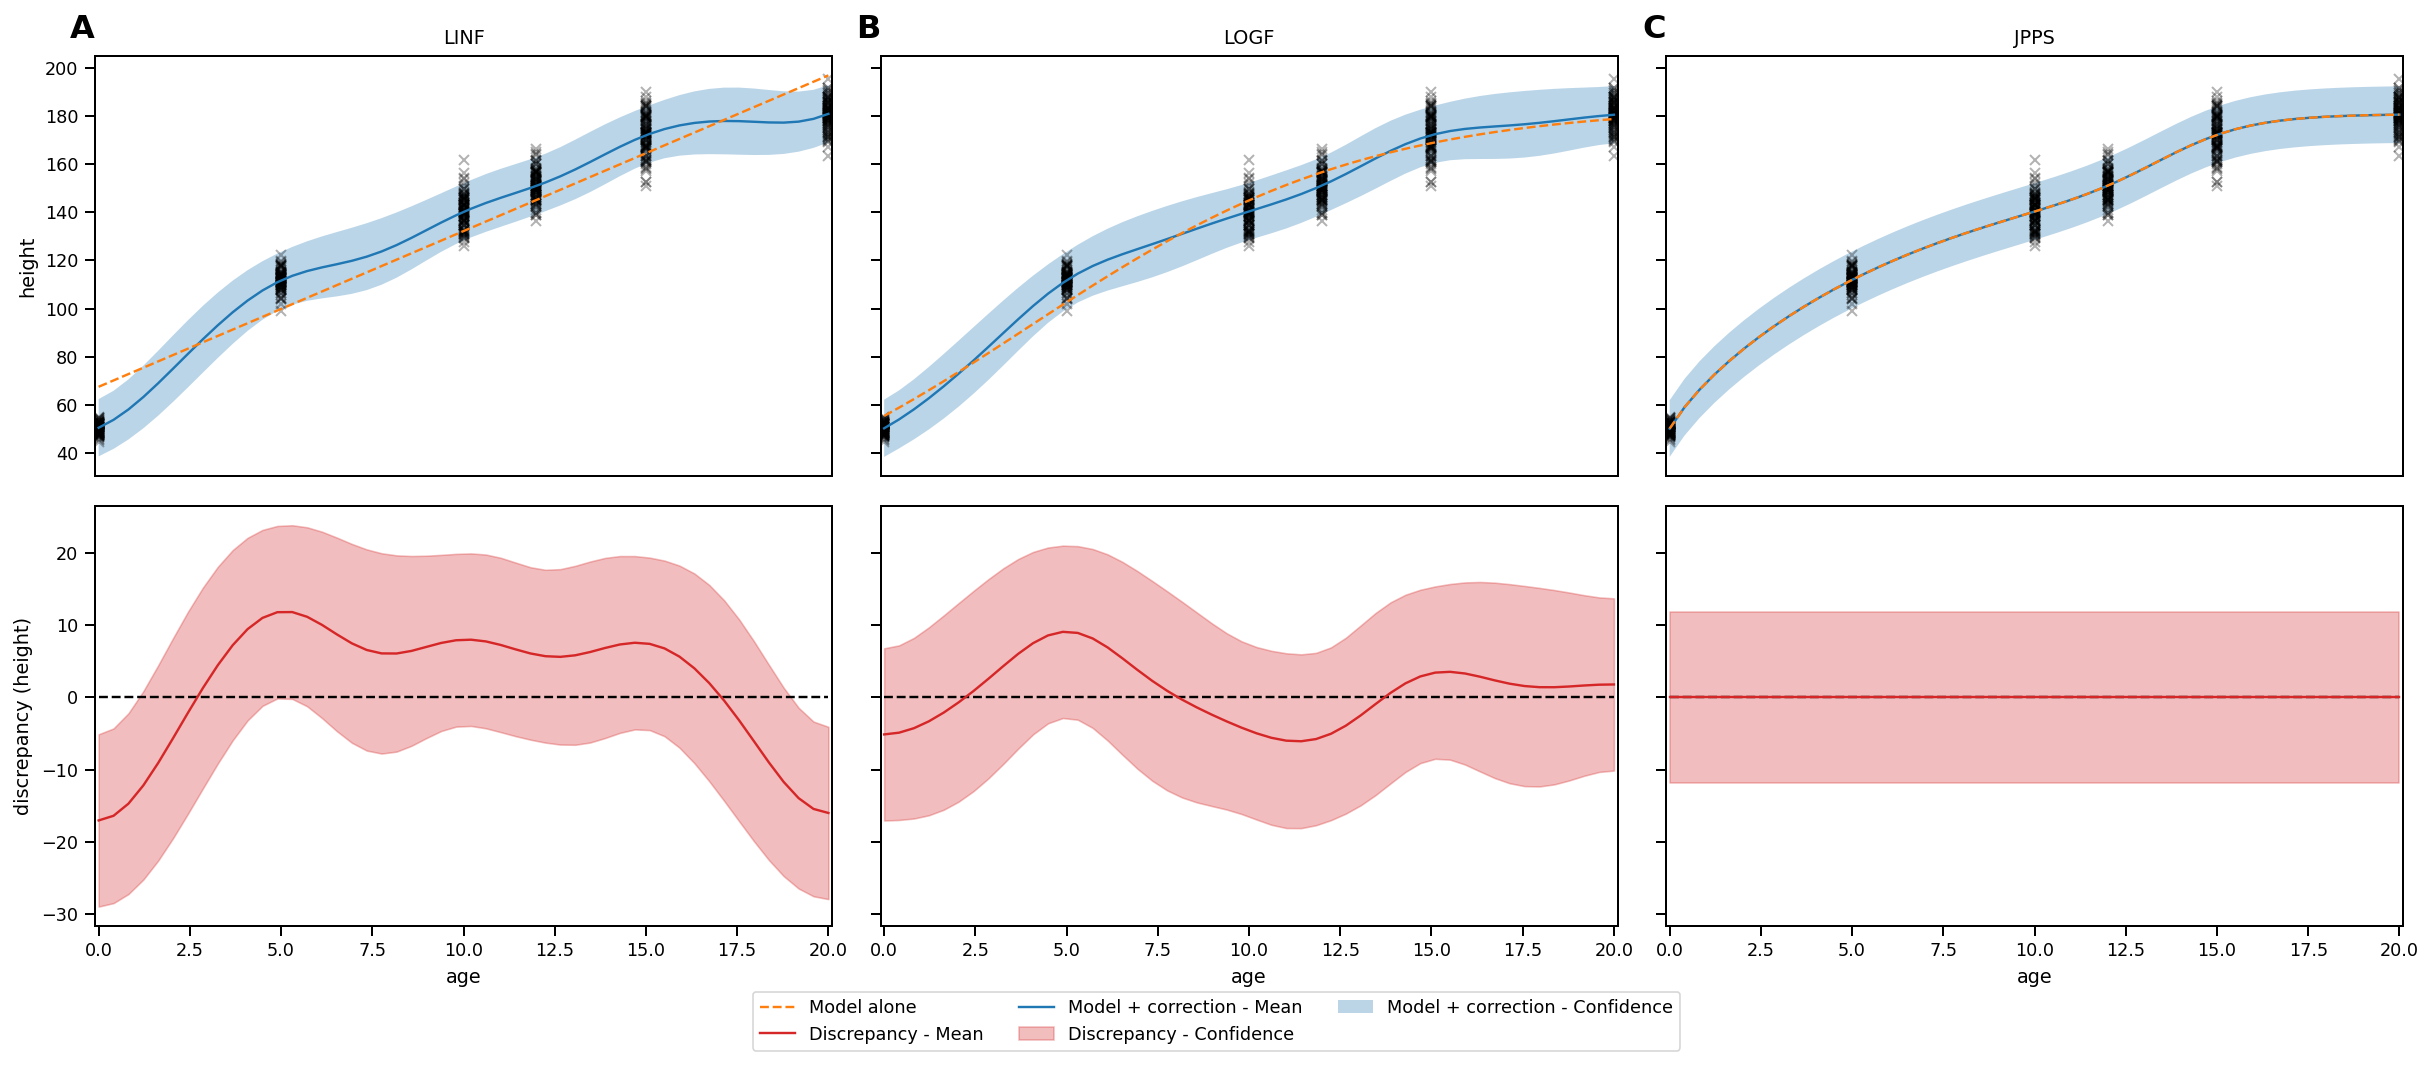

In [53]:
# Initialize plot
fig, axes = plt.subplots(figsize=(17, 7), nrows=2, ncols=3)

err_max = - np.inf
err_min = np.inf
h_max = - np.inf
h_min = np.inf

letter_idx = 0
letters = 'A', 'B', 'C', 'D', 'E', 'F'

for c_idx, m_name in enumerate(("Linf", "Logf", "Jpps")):
    
    dm = df_dm.loc[m_name, "dm"]
    title = m_name.upper()
    
    # extract data
    train_x = data.age.values
    train_y = data.height.values

    # Pickup testing points        
    test_x = torch.linspace(0, train_x.max(), 50).double()

    # Get mean, lower and upper confidence bounds
    m_pred, gp_mean, gp_lower, gp_upper = dm.pred(test_x)

    # Convert to numpy for plot
    test_x = test_x.numpy()

    # -------------------------------------------------------------------- #
    
    ax = axes[0, c_idx]

    # Plot training data as black stars
    h_obs, = ax.plot(train_x, train_y, 'x', label='Observations', alpha=0.3, color='black')
    # Plot predictive means as blue line
    h_mean, = ax.plot(test_x, gp_mean, 'C0', label="Model + correction - Mean")
    # Shade between the lower and upper confidence bounds
    h_conf = ax.fill_between(test_x, gp_lower, gp_upper, alpha=0.3, label="Model + correction - Confidence")

    # Plot model predictions
    h_model, = ax.plot(test_x, m_pred, color='C1', ls="--", label="Model alone")

    if c_idx == 0:
        ax.set_ylabel("height")
    else:
        ax.set_yticklabels([])
        
    ax.set_title(title)
    
    ax.set_xticks([])
    
    ax.text(0, 1.1, letters[letter_idx], transform=ax.transAxes, fontsize=16, 
            fontweight='bold', va='top', ha='right')
    letter_idx += 1
    
    y_lim = ax.get_ylim()
    h_min = min(h_min, y_lim[0])
    h_max = max(h_max, y_lim[1])

    # -------------------------------------------------------------------- #
    
    ax = axes[1, c_idx]

    # Add horizontal line
    ax.hlines(y=0, ls="--", xmin=test_x.min(), xmax=test_x.max(), color="black")

    # Compute correction
    corr = gp_mean - m_pred 
    corr_lower = gp_lower - m_pred
    corr_upper = gp_upper - m_pred

    # Plot correction and CI
    h_corr_mean, = ax.plot(test_x, corr, color='C3', label="Discrepancy - Mean")
    h_corr_conf = ax.fill_between(test_x, corr_lower, corr_upper, 
                                  alpha=0.3, 
                                  label="Discrepancy - Confidence",
                                  color='C3', )

    # Add legend / title / format axis
    ax.set_xlabel("age")
    
    y_lim = ax.get_ylim()
    err_min = min(err_min, y_lim[0])
    err_max = max(err_max, y_lim[1])

    if c_idx == 0:
        ax.set_ylabel("discrepancy (height)")
    else:
        ax.set_yticklabels([])
        
# -------------------------------------------------------------------- #

for c_idx in range(3):
    axes[0, c_idx].set_ylim(h_min, h_max)      
    axes[1, c_idx].set_ylim(err_min, err_max)

for ax in axes.flatten():
    ax.set_xlim(data.age.min()-0.1, data.age.max()+0.1)

fig.legend(handles=[h_model, h_corr_mean, h_mean, h_corr_conf, h_conf], 
           bbox_to_anchor=(0.5,-0.05), loc="lower center", 
           bbox_transform=fig.transFigure, ncol=3)

fig.tight_layout()

os.makedirs("fig", exist_ok=True)
plt.savefig("fig/growth.pdf", bbox_inches='tight')

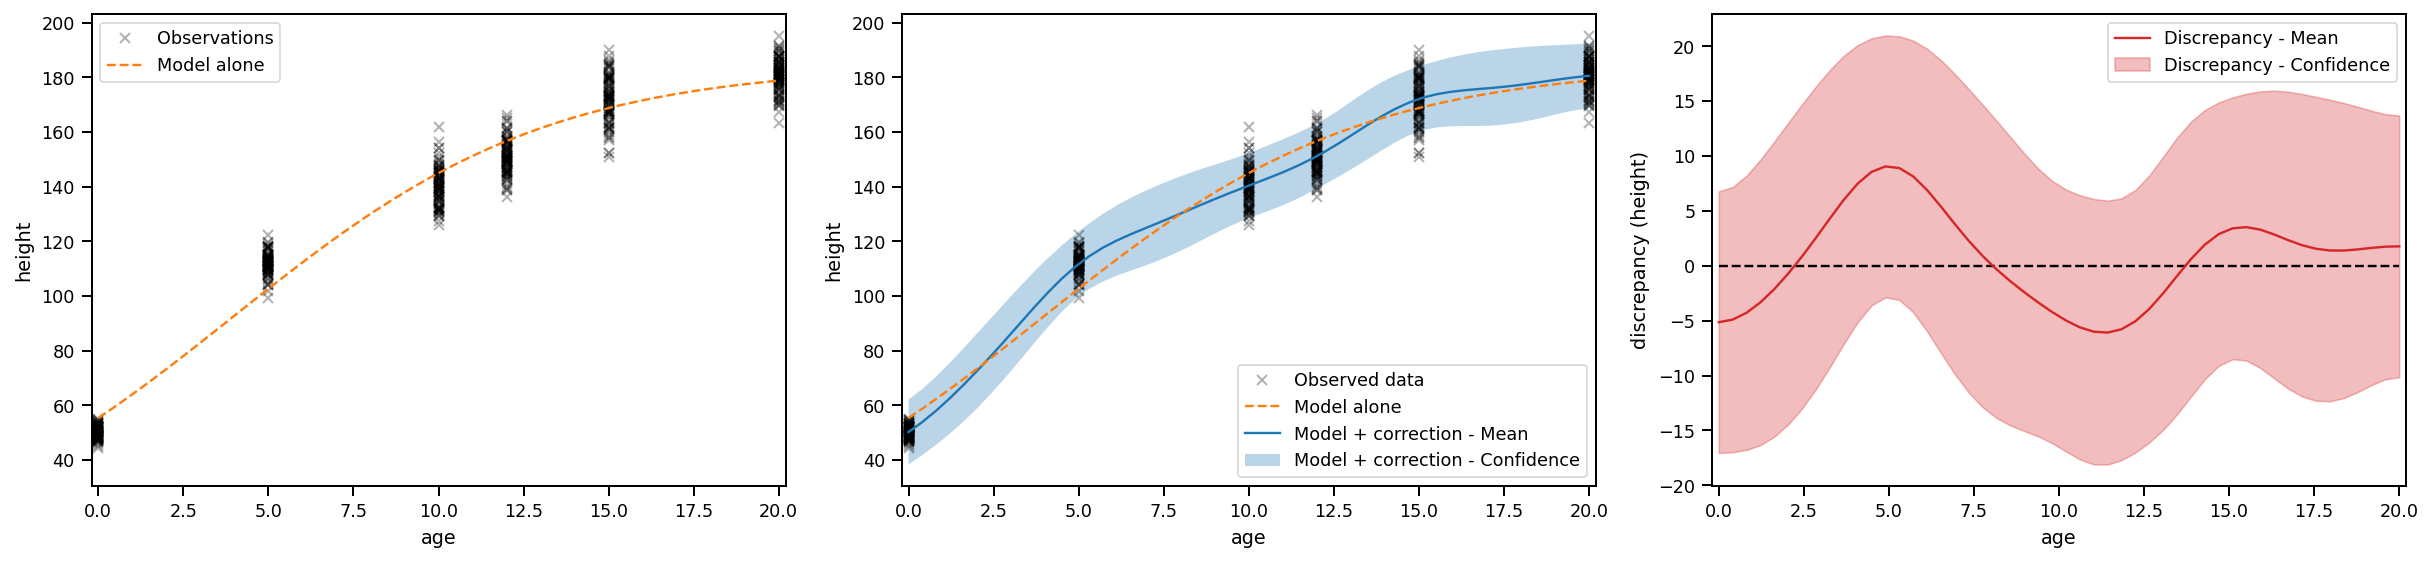

In [54]:
# Initialize plot
fig, axes = plt.subplots(figsize=(17, 4), nrows=1, ncols=3)

m_name = "Logf"
    
dm = df_dm.loc[m_name, "dm"]
title = m_name.upper()

h_min = np.inf
h_max = - np.inf

# extract data
train_x = data.age.values
train_y = data.height.values

# Pickup testing points        
test_x = torch.linspace(0, train_x.max(), 50).double()

# Get mean, lower and upper confidence bounds
m_pred, gp_mean, gp_lower, gp_upper = dm.pred(test_x)

# Convert to numpy for plot
test_x = test_x.numpy()

# ---------------------------------------------------------- #

ax = axes[0]

# Plot training data as black stars
h_obs, = ax.plot(train_x, train_y, 'x', label='Observations', alpha=0.3, color='black')

# Plot model predictions
h_model, = ax.plot(test_x, m_pred, color='C1', ls="--", label="Model alone")

# Add legend / title / format axis
ax.legend(handles=[h_obs, h_model, ],)
ax.set_xlabel("age")
ax.set_ylabel("height")

y_lim = ax.get_ylim()
h_min = min(h_min, y_lim[0])
h_max = max(h_max, y_lim[1])

# ---------------------------------------------------------- #

ax = axes[1]

# Plot training data as black stars
h_obs, = ax.plot(train_x, train_y, 'x', label='Observed data', alpha=0.3, color='black')
# Plot predictive means as blue line
h_mean, = ax.plot(test_x, gp_mean, 'C0', label="Model + correction - Mean")
# Shade between the lower and upper confidence bounds
h_conf = ax.fill_between(test_x, gp_lower, gp_upper, alpha=0.3, label="Model + correction - Confidence")

# Plot model predictions
h_model, = ax.plot(test_x, m_pred, color='C1', ls="--", label="Model alone")

# Add legend / title / format axis
ax.legend(handles=[h_obs, h_model, h_mean, h_conf ],)
ax.set_xlabel("age")
ax.set_ylabel("height")

y_lim = ax.get_ylim()
h_min = min(h_min, y_lim[0])
h_max = max(h_max, y_lim[1])

# --------------------------------------------------------- #

ax = axes[2]

# Add horizontal line
ax.hlines(y=0, ls="--", xmin=test_x.min(), xmax=test_x.max(), color="black")

# Compute correction
corr = gp_mean - m_pred 
corr_lower = gp_lower - m_pred
corr_upper = gp_upper - m_pred

# Plot correction and CI
h_corr_mean, = ax.plot(test_x, corr, color='C3', label="Discrepancy - Mean")
h_corr_conf = ax.fill_between(test_x, corr_lower, corr_upper, 
                              alpha=0.3, 
                              label="Discrepancy - Confidence",
                              color='C3', )

# Add legend / title / format axis
ax.set_xlabel("age")
ax.set_ylabel("discrepancy (height)")
ax.legend(handles=[h_corr_mean, h_corr_conf])

# -------------------------------------------------------- #

for i, ax in enumerate(axes):
    if i < 2:
        ax.set_ylim(h_min, h_max)
    ax.set_xlim(data.age.min()-0.2, data.age.max()+0.2)

fig.tight_layout()

os.makedirs("fig", exist_ok=True)
plt.savefig("fig/teaser.pdf", bbox_inches='tight')